# **FOREWORD**

This work is based on the amazing baseline notebook from Ravi: https://www.kaggle.com/code/ravi20076/playgrounds5e11-public-baseline-v1

I've modified to use Autogluon instead.

## Installing autogluon

This used to be a pain with pip. Now, `uv` works so much better.

In [1]:
!uv pip install autogluon

Using Python 3.11.13 environment at: /usr
Resolved 229 packages in 5.72s
   Building seqeval==1.2.2
   Building seqeval==1.2.2
   Building nvidia-ml-py3==7.352.0
   Building seqeval==1.2.2
   Building nvidia-ml-py3==7.352.0
⠙ Preparing packages... (0/51)
   Building seqeval==1.2.2
   Building nvidia-ml-py3==7.352.0
⠙ Preparing packages... (0/51)
   Building seqeval==1.2.2
   Building nvidia-ml-py3==7.352.0
⠙ Preparing packages... (0/51)
psutil     ------------------------------     0 B/271.47 KiB
   Building seqeval==1.2.2
   Building nvidia-ml-py3==7.352.0
⠙ Preparing packages... (0/51)
opencensus ------------------------------     0 B/125.22 KiB
psutil     ------------------------------     0 B/271.47 KiB
   Building seqeval==1.2.2
   Building nvidia-ml-py3==7.352.0
⠙ Preparing packages... (0/51)
dill       ------------------------------     0 B/113.53 KiB
opencensus ------------------------------     0 B/125.22 KiB
psutil     ------------------------------     0 B/271.47 KiB
   Buil

In [2]:
import warnings, torch
import pandas as pd, numpy as np
from itertools import combinations
from tqdm.notebook import tqdm
warnings.simplefilter('ignore')


In [3]:
import os
def is_interactive():
   return os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == "Interactive"
print("is interactive session?", is_interactive())
preset_quality = "medium_quality" if is_interactive() else "best_quality"

time_limit = 60 if is_interactive() else 60 * 9#3600

is interactive session? False


# **PREPROCESSING**

In [4]:

train = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')
orig = pd.read_csv('/kaggle/input/loan-prediction-dataset-2025/loan_dataset_20000.csv')

print('Train Shape:', train.shape)
print('Test Shape:', test.shape)
print('Orig Shape:', orig.shape)

TARGET = 'loan_paid_back'
CATS   = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
BASE   = [col for col in train.columns if col not in ['id', TARGET]]

Train Shape: (593994, 13)
Test Shape: (254569, 12)
Orig Shape: (20000, 22)


# **FEATURE ENGINEERING**

In [5]:

INTER = []

for col1, col2 in tqdm(combinations(BASE, 2)):
    new_col_name = f'{col1}_{col2}'
    INTER.append(new_col_name)
    for df in [train, test, orig] :
        df[new_col_name] = df[col1].astype(str) + '_' + df[col2].astype(str)
        
print(f'{len(INTER)} Features')

for col1, col2, col3 in combinations(CATS, 3 ):
    new_col_name = f'{col1}_{col2}_{col3}'
    INTER.append(new_col_name)
    for df in [train, test, orig]:
        df[new_col_name] = df[col1].astype(str) + '_' + df[col2].astype(str) + df[col3].astype(str)
        
print(f'{len(INTER)} Features')

ORIG = []

for col in BASE:
    # MEAN
    mean_map = orig.groupby(col)[TARGET].mean()
    new_mean_col_name = f"orig_mean_{col}"
    mean_map.name = new_mean_col_name
    
    train = train.merge(mean_map, on=col, how='left')
    test = test.merge(mean_map, on=col, how='left')
    ORIG.append(new_mean_col_name)

    # COUNT
    new_count_col_name = f"orig_count_{col}"
    count_map = orig.groupby(col).size().reset_index(name=new_count_col_name)
    
    train = train.merge(count_map, on=col, how='left')
    test  = test.merge(count_map, on=col, how='left')
    ORIG.append(new_count_col_name)

print(len(ORIG), 'Orig Features Created!!')

FEATURES = BASE + ORIG + INTER
print(len(FEATURES), 'Features.')

X = train[FEATURES]
y = train[TARGET]

0it [00:00, ?it/s]

55 Features
75 Features
22 Orig Features Created!!
108 Features.


# **MODEL TRAINING**

In [6]:
train

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,...,orig_mean_marital_status,orig_count_marital_status,orig_mean_education_level,orig_count_education_level,orig_mean_employment_status,orig_count_employment_status,orig_mean_loan_purpose,orig_count_loan_purpose,orig_mean_grade_subgrade,orig_count_grade_subgrade
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,...,0.799579,9031,0.808076,5919,0.885734,2923,0.802745,2550,0.821004,1514
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,...,0.800312,8974,0.797798,3724,0.886984,13007,0.799399,7981,0.727749,1146
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,...,0.799579,9031,0.808076,5919,0.886984,13007,0.799399,7981,0.831224,1422
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,...,0.799579,9031,0.808076,5919,0.886984,13007,0.799399,7981,0.653722,309
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,...,0.800312,8974,0.808076,5919,0.886984,13007,0.802745,2550,0.757576,1155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593989,593989,23004.26,0.152,703,20958.37,10.92,Female,Single,High School,Employed,...,0.799579,9031,0.808076,5919,0.886984,13007,0.809085,1629,0.821004,1514
593990,593990,35289.43,0.105,559,3257.24,14.62,Male,Single,Bachelor's,Employed,...,0.799579,9031,0.791299,8045,0.886984,13007,0.799399,7981,0.705882,340
593991,593991,47112.64,0.072,675,929.27,14.13,Female,Married,Bachelor's,Employed,...,0.800312,8974,0.791299,8045,0.886984,13007,0.799399,7981,0.850355,1410
593992,593992,76748.44,0.067,740,16290.40,9.87,Male,Single,Bachelor's,Employed,...,0.799579,9031,0.791299,8045,0.886984,13007,0.799399,7981,0.915902,654


In [7]:
from autogluon.tabular import  TabularDataset, TabularPredictor

## Training and Predicting

In [8]:
!ls /tmp

clean-layer.sh	kaggle.log  tmpqd00fe5v.json  uv-b17927aca3d28934.lock


In [9]:
predictor = TabularPredictor(label = TARGET)

print(preset_quality, time_limit)
# TRAIN AUTOGLUON
predictor.fit(train,
              presets = preset_quality,
              time_limit = time_limit,
              auto_stack = True,
              #num_bag_folds = 7,
              #num_bag_sets = 3,
              num_cpus = 4,
              verbosity = 1,
              #ag_args_fit={'num_gpus': 1}
             )

No path specified. Models will be saved in: "AutogluonModels/ag-20251102_084802"


best_quality 540


2025-11-02 08:48:06,642	INFO worker.py:1843 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
(_dystack pid=272) 	Warning: Data size prior to feature transformation consumes 14.2% of available memory. Consider increasing memory or subsampling the data to avoid instability.


In [10]:
predictor.leaderboard()


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L1,0.908322,accuracy,14.260332,177.431304,14.260332,177.431304,1,True,1
1,WeightedEnsemble_L3,0.908322,accuracy,14.306501,179.090812,0.046168,1.659509,3,True,5
2,WeightedEnsemble_L2,0.908322,accuracy,14.319388,178.559668,0.059056,1.128365,2,True,3
3,LightGBMXT_BAG_L2,0.904917,accuracy,22.647976,290.910668,5.101434,71.294044,2,True,4
4,LightGBM_BAG_L1,0.798820,accuracy,3.286209,42.185321,3.286209,42.185321,1,True,2


In [11]:
importance_df = predictor.feature_importance(train[:100])

importance_df.style.background_gradient(subset=['importance', 'stddev'], cmap='Blues')

,importance,stddev,p_value,n,p99_high,p99_low
orig_mean_debt_to_income_ratio,0.030000,0.000000,0.500000,5,0.030000,0.030000
debt_to_income_ratio,0.026000,0.005477,0.000223,5,0.037278,0.014722
debt_to_income_ratio_employment_status,0.022000,0.004472,0.000194,5,0.031208,0.012792
employment_status,0.022000,0.008367,0.002091,5,0.039227,0.004773
debt_to_income_ratio_gender,0.012000,0.004472,0.001941,5,0.021208,0.002792
credit_score,0.010000,0.007071,0.017055,5,0.024559,-0.004559
orig_mean_credit_score,0.008000,0.008367,0.049650,5,0.025227,-0.009227
orig_mean_annual_income,0.006000,0.005477,0.035242,5,0.017278,-0.005278
employment_status_grade_subgrade,0.006000,0.011402,0.152279,5,0.029476,-0.017476
debt_to_income_ratio_education_level,0.002000,0.004472,0.186950,5,0.011208,-0.007208


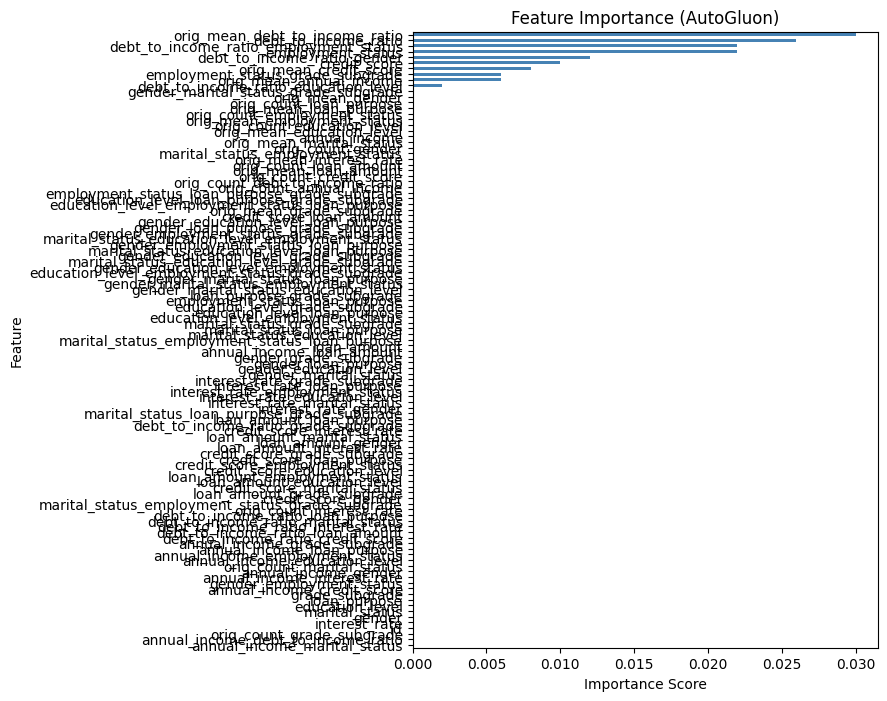

In [12]:
import matplotlib.pyplot as plt
imp = importance_df['importance'].sort_values(ascending=True)

plt.figure(figsize=(6, 8))
imp.plot(kind='barh', color='steelblue')
plt.title('Feature Importance (AutoGluon)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [13]:

# TEST DATA PREDICTION
y_test = predictor.predict(test)

submission = pd.read_csv(
        f"/kaggle/input/playground-series-s5e11/sample_submission.csv")

submission["loan_paid_back"] = y_test

submission.to_csv("submission.csv")
submission

,id,loan_paid_back
0,593994,1.0
1,593995,1.0
2,593996,1.0
3,593997,1.0
4,593998,1.0
...,...,...
254564,848558,1.0
254565,848559,1.0
254566,848560,1.0
254567,848561,1.0
